# Drivers of Reddit NFL sentiment
This notebook investigates what drives the sentiment of NFL players on reddit. It roughly has N parts:
1. Building a set of covariates for sentiment (e.g. player demographics, city demographics, performance data)
2. Calculating the sentiment towards each player
3. Performing a regression model to predict player sentiment

This is a work in progress. For similar work on the NFL, see `nba-sentiment.ipynb`.

### Short term to-do:
* Clean up comment matching
  * Why does JJ Watt have low comment count?
* Add salary data and Trump vote share
* Try to find some subset of data where performance is correlated with sentiment

### Long term to-do:

Create functions for:
  * fuzzy matching cleanup
  * aggregation (maybe)

In [47]:
import json
import string
import requests
import re
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ast import literal_eval
from string import punctuation
from sner import Ner
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sports_sentiment as ss
import scrape_player_data as spd

In [3]:
# download stanford core nlp (should be a zip file of format stanford-ner-YYYY-MM-DD) (maybe from https://nlp.stanford.edu/software/CRF-NER.shtml#Download)
# need to start the Java server:
# cd C:\ProgramData\Anaconda3\Lib\site-packages\sner\stanford-ner-2018-02-27
# java -Djava.ext.dirs=./lib -cp stanford-ner.jar edu.stanford.nlp.ie.NERServer -port 9199 -loadClassifier ./classifiers/english.all.3class.distsim.crf.ser.gz  -tokenizerFactory edu.stanford.nlp.process.WhitespaceTokenizer -tokenizerOptions tokenizeNLs=false

In [4]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

## Constants and non-text data

In [5]:
non_players_set = set('Baltimore Ravens Buffalo Bills Cincinnati Bengals Cleveland Browns Denver Broncos Houston Texans Indianapolis Colts ' \
                        'Jacksonville Jaguars Kansas City Chiefs Los Angeles Chargers Miami Dolphins New England Patriots New York Jets ' \
                        'Oakland Raiders Pittsburgh Steelers Tennessee Titans NFL Bowl ' \
                       'Arizona Cardinals Atlanta Falcons Carolina Panthers Chicago Bears Dallas Cowboys Detroit Lions Green Bay Packers ' \
                        'Los Angeles Rams Minnesota Vikings New Orleans Saints New York Giants Philadelphia Eagles San Francisco 49ers ' \
                        'Seattle Seahawks Tampa Bay Buccaneers Washington Redskins ' \
                        'Goodell Lebron jags cards hawks bucs skins'.lower().split())

In [7]:
coaches_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_coach_performance.tsv', sep='\t')
coaches_race_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_coach_race.tsv', sep='\t')
coaches = set([name for coach in list(coaches_race_df.iloc[:,0]) for name in coach.split(' ')] )

## Load covariates
### Covariates contains only skill position players

In [8]:
covariates_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_player_covariates.tsv', sep='\t')
covariates_df.head(2)

,Player_FO,Tm,position,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,year,player_join,Player,level_1,start_year,end_year,url,height,weight,birth_date,race,salary,standard_salary,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
0,T.Brady,BOS,qb,2035,35.1,34,2.574492,1.846341,1.437475,2012,t brady,tom brady,12.0,2000.0,2018.0,/players/B/BradTo00.htm,76.0,225.0,"August 3, 1977",W,NaN,NaN,12.0,4728844.0,77.3,8.0,0.3815,12.0
1,P.Manning,DEN,qb,1805,32.8,37,2.222644,1.738123,1.722051,2012,p manning,peyton manning,14.0,1998.0,2015.0,/players/M/MannPe00.htm,77.0,230.0,"March 24, 1976",W,NaN,NaN,13.0,2752056.0,81.9,5.6,0.5638,14.0


#### Also load all players so that we can get names for entity extraction

In [9]:
demo_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_players2010-2018.tsv', sep ='\t', encoding = 'utf-8')
demo_df['Player'] = demo_df['Player'].str.lower()

In [10]:
def create_month_df(data_loc):
    return ss.create_sentiment_df(data_loc, sid.polarity_scores, ner_set=NAMED_ENTITIES,
                                  non_players_set=non_players_set, UPPER_NAMES = UPPER_ENTITIES)

### Instantiate sentiment analyzer
For sentiment, I use a modified version of VADER. Many words have different sentiment in the sports world as compared to general usage (e.g. "offensive" is not a negative word in sports).

In [13]:
sid = SentimentIntensityAnalyzer()
stat_words = ['steal', 'steals', 'block', 'blocked', 'blocks', 'slam', 'charges', 'rejection', 'free', 'assists', 'win',
              'championship', 'championships']
neutral_words = ['offense', 'offensive', 'offensively', 'defense', 'defensive', 'defensively', 'defender',
                 'injury', 'injured', 'strain', 'questionable', 'isolation', 'attack',
                 'shoot', 'doubtful', 'play', 'plays', 'crazy', 'turnover', 'turnovers',
                 'seriously', 'rob', 'freeman', 'hardy', 'threat', 'loss', 'losses', 'playing']
bad_words = ['foul', 'vicious', 'ridiculous', 'motherfucking', 'mediocre', 'soft',
             'garbage', 'delusional', 'slow', 'douchey', 'cheap', 'creepy']
great_words = ['goat', 'nasty', 'prime', 'mvp', 'master', 'all-star']
sid.lexicon.update({word:0.1 for word in stat_words})
sid.lexicon.update({word:0 for word in neutral_words})
sid.lexicon.update({word:-0.5 for word in bad_words})
sid.lexicon.update({word:1 for word in great_words})

In [14]:
city_mapping = {'ARI':'PHO', 'CAR':'CHO', 'GNB':'GB', 'JAX':'JAC', 'KAN':'KC', 'LACH':'LAC', 'LARM':'LAR',
                'NE':'BOS', 'NWE':'BOS', 'NOR':'NOP', 'NO':'NOP', 'SD':'SDG','SFO':'SF', 'TAM':'TB',
                'New England Patriots': 'BOS', 'Miami Dolphins': 'MIA', 'New York Jets': 'NYJ', 'Buffalo Bills': 'BUF',
                'Baltimore Ravens': 'BAL', 'Cincinnati Bengals': 'CIN', 'Pittsburgh Steelers': 'PIT', 'Cleveland Browns': 'CLE',
                'Houston Texans': 'HOU', 'Indianapolis Colts': 'IND', 'Tennessee Titans': 'TEN', 'Jacksonville Jaguars': 'JAC',
                'Denver Broncos': 'DEN', 'San Diego Chargers': 'SDG', 'Oakland Raiders': 'OAK', 'Kansas City Chiefs': 'KC',
                'Washington Redskins': 'WAS', 'New York Giants': 'NYG', 'Dallas Cowboys': 'DAL', 'Arizona Cardinals': 'PHO',
                'Philadelphia Eagles': 'PHI', 'Green Bay Packers': 'GB', 'Minnesota Vikings': 'MIN',
                'Chicago Bears': 'CHI', 'Detroit Lions': 'DET', 'Atlanta Falcons': 'ATL', 'Carolina Panthers': 'CHO',
                'New Orleans Saints': 'NOP', 'Tampa Bay Buccaneers': 'TB', 'San Francisco 49ers': 'SF', 'Seattle Seahawks': 'SEA',
                'St. Louis Rams': 'STL', 'Los Angeles Chargers': 'LAC', 'Los Angeles Rams': 'LAR' }

#### Player names for entity recognition and fuzzy matching
When extracting named entities, I had to be careful with some names that are common English words (e.g. "Brown"). As a shorter alternative to performing NER, I also sometimes simply extracted player names as keywords.

In [26]:
UNIQUE_NAMES = {x.replace('\\', '') for x in set(demo_df.Player.unique())}
UNIQUE_NAMES = UNIQUE_NAMES.union(set(coaches_race_df.iloc[:,0].str.lower()))

In [54]:
NAMED_ENTITIES = set(' '.join(UNIQUE_NAMES).split()).union({'rg3', 'obj', 'saquads', 'cantguardmike', 'tractorcito', 'bmarsh',
                                                            'berman', 'coughlin', 'dungy', 'mcdaniels', 'spanos', 'gronk', 'bledsoe', 'garopolo'})
NAMED_ENTITIES = NAMED_ENTITIES.union(non_players_set)
# some players have common word names; don't want to detect those as entities when lowercase, but do want to when uppercase
UPPER_ENTITIES = {'Ah', 'Black', 'Ball', 'Battle', 'Bell', 'Best', 'Blue', 'Board', 'Brown', 'Buddy', 'Burden',
                  'Case', 'Chance', 'Choice', 'City', 'Cook', 'Dare', 'Day', 'Early',
                  'Fish', 'Free', 'Grant', 'Good', 'Hand', 'Heard', 'Hill', 'Hope', 'Hurt', 'House', 'Holiday', 'Key',
                  'Little', 'Guy', 'Long', 'Love', 'Light', 'Line', 'Luck', 'Major', 'Means', 'New', 
                  'Pace', 'Person', 'Petty','Pool', 'Price','Rob', 'Rose', 'Red', 'Rock', 'Rush',
                  'Savage', 'Season', 'Short', 'Shorts', 'Strong', 'Small', 'Smart', 'Star', 'Stone', 'Story', 
                  'Temple', 'Tuck', 'Wall', 'Wear', 'Weeks', 'White', 'Will', 'Way', 'West', 'Wise', 'Young', }
NAMED_ENTITIES = NAMED_ENTITIES - {'a', 'g', 'ah', 'you', 'has', 'good', 'still'} - {name.lower() for name in UPPER_ENTITIES}
# remove periods for some names
table = str.maketrans({key: None for key in string.punctuation})
NOPUNCT_ENTITIES = {name.translate(table) for name in NAMED_ENTITIES}
NAMED_ENTITIES = NAMED_ENTITIES.union(NOPUNCT_ENTITIES)

## Calculate sentiment 
### Reddit sentiment for 2017-18 season
I created a module, `sentiment_sports` to calculate the sentiment of comments. This function performs a few things:
1. Separates comments into sentences
2. Performs Named entity recognition using either NLTK, or using pre-existing list of entities
3. Calculates sentiment using VADER with a modified lexicon

In [ ]:
%%time
_, sep_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201709-comments_submissions.tsv')
_, oct_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201710-comments_submissions.tsv')
_, nov_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201711-comments_submissions.tsv')
_, dec_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201712-comments_submissions.tsv')
_, jan_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201801-comments_submissions.tsv')
_, feb_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201802-comments_submissions.tsv')

In [61]:
#600k pre non_player filter
nfl2017_df = pd.concat([sep_df, oct_df, nov_df, dec_df, jan_df, feb_df])
nfl2017_df.shape

(663750, 15)

In [62]:
%%time
# 27 minutes with 8 cores
nfl2017_df = ss.fuzzy_match_players(nfl2017_df, UNIQUE_NAMES)

Fuzzy matching player names
Wall time: 20min 18s


In [63]:
nfl2017_df.to_csv('d:/data/sentiment_sports/nfl2017_ner_sentiment.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2016-2017 season

In [ ]:
%%time
year =2016
_, sep_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}09-comments_submissions.tsv')
_, oct_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}10-comments_submissions.tsv')
_, nov_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}11-comments_submissions.tsv')
_, dec_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}12-comments_submissions.tsv')
_, jan_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year+1}01-comments_submissions.tsv')
_, feb_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year+1}02-comments_submissions.tsv')

In [65]:
nfl2016_df = pd.concat([sep_df, oct_df, nov_df, dec_df, jan_df, feb_df])
nfl2016_df.shape

(518647, 15)

In [66]:
%%time
# 27 minutes with 8 cores
nfl2016_df = ss.fuzzy_match_players(nfl2016_df, UNIQUE_NAMES)

Fuzzy matching player names
Wall time: 19min 49s


In [68]:
nfl2016_df.to_csv('d:/data/sentiment_sports/nfl2016_ner_sentiment.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2015-2016 season

In [ ]:
%%time
year =2015
_, sep_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}09-comments_submissions.tsv')
_, oct_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}10-comments_submissions.tsv')
_, nov_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}11-comments_submissions.tsv')
_, dec_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}12-comments_submissions.tsv')
_, jan_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year+1}01-comments_submissions.tsv')
_, feb_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year+1}02-comments_submissions.tsv')

In [69]:
nfl2015_df = pd.concat([sep_df, oct_df, nov_df, dec_df, jan_df, feb_df])
nfl2015_df.shape

(522973, 15)

In [70]:
%%time
# 27 minutes with 8 cores
nfl2015_df = ss.fuzzy_match_players(nfl2015_df, UNIQUE_NAMES)

Fuzzy matching player names
Wall time: 20min 4s


In [71]:
nfl2015_df.to_csv('d:/data/sentiment_sports/nfl2015_ner_sentiment.tsv', sep='\t',
               index=False, encoding = 'utf-8')

### Load comment sentiment

In [12]:
nfl2015_df = pd.read_csv('d:/data/sentiment_sports/nfl2015_ner_sentiment.tsv',sep='\t', encoding = 'utf-8')
nfl2015_df['named_entities'] = nfl2015_df['named_entities'].apply(literal_eval)
nfl2016_df = pd.read_csv('d:/data/sentiment_sports/nfl2016_ner_sentiment.tsv',sep='\t', encoding = 'utf-8')
nfl2016_df['named_entities'] = nfl2016_df['named_entities'].apply(literal_eval)
nfl2017_df = pd.read_csv('d:/data/sentiment_sports/nfl2017_ner_sentiment.tsv',sep='\t', encoding = 'utf-8')
nfl2017_df['named_entities'] = nfl2017_df['named_entities'].apply(literal_eval)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
nfl2015_df['year'] = 2015
nfl2016_df['year'] = 2016
nfl2017_df['year'] = 2017

In [14]:
nfl_df = pd.concat([nfl2015_df, nfl2016_df, nfl2017_df])

#### Cleaning up name matches
Some extracted name entities don't have a clear match (e.g. "Rivers" could be Austin Rivers or Doc Rivers). Here we clean those out

In [16]:
name_map = {name:'unclear' for name in ['rivers', 'bird', 'brady moss']}
name_map.update({'barr':'anthony barr', 'bmarsh':'brandon marshall', 'brady': 'tom brady', 'carr':'derek carr', 
                 'carson': 'carson palmer', 'clowney': 'jadeveon clowney', 'cousins': 'kirk cousins', 'crabtree':'michael crabtree', 
                'dak':'dak prescott', 'dalton':'andy dalton', 'dez': 'dez bryant', 'eli': 'eli manning', 'ertz':'zach ertz', 'freeman':'devonta freeman',
                 'goff':'jared goff', 'gore':'frank gore', 'gronk':'rob gronkowski', 'gurley':'todd gurley',
                 'ingram': 'mark ingram', 'jj': 'j.j. watt', 'kamara':'alvin kamara', 'kelce': 'travis kelce',
                 'landry': 'jarvis landry', 'mccarron':'aj mccarron', 'obj': 'odell beckham',
                 'peyton':'peyton manning', 'peterman':'nathan peterman', 'pryor':'terrelle pryor',
                 'rodgers':'aaron rodgers', 'stafford':'matthew stafford', 'saquads': 'saquon barkley', 'tractorcito': 'derrick henry',
                'vick': 'michael vick', 'watt':'j.j. watt'})

In [17]:
%%time
nfl_df['fuzzy_name'] = nfl_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)

Wall time: 32 s


Remove players whose names have implicit sentiment

In [18]:
senti_players = ['maurice hurt', 'chris hope', 'tom savage', 'chandler burden', 'bryce petty',
                 'andrew luck', 'lucky whitehead', 'jahvid best', 'champ bailey']
nfl_df = nfl_df[nfl_df['fuzzy_name'].apply(lambda row: row not in senti_players)]

#### Query to investigate non-mappings

#### Combine seasons into a single dataframe

In [19]:
match_df = nfl_df.query('fuzzy_name != "unclear"')
match_df.shape

(832405, 17)

### User-level metrics

In [84]:
user_df = match_df.groupby('user').agg({'score':['sum', 'count', 'mean']}).fillna(0)
user_df.columns = ['user_total_score', 'user_total_comments', 'user_mean_score']

#### First calculate the average sentiment for each player from each user

In [24]:
user_player_sentiment_df = (match_df.groupby(['fuzzy_name', 'user', 'year', 'flair'])
                                    .agg({'compound':['mean', 'std', 'count']})
                                    .reset_index())
user_player_sentiment_df.columns = ['fuzzy_name', 'user', 'year', 'flair', 'compound_mean', 'compound_std', 'comment_count']
user_player_sentiment_df.head(1)

,fuzzy_name,user,year,flair,compound_mean,compound_std,comment_count
0,a'shawn robinson,AshytooClassy,2017,Lions,0.0,NaN,1


#### Match user flairs to teams

In [89]:
city_mapping.update({'Falcons':'ATL', 'Ravens':'BAL', 'Patriots':'BOS', 
                     'Panthers':'CHO', 'Browns':'CLE', 'Bears':'CHI',
                'Cowboys':'DAL', 'Broncos':'DEN', 'Lions':'DET', 
                'Lakers':'LAL', 'Rams':'LAR', 
              'Giants':'NYG',  'Jets':'NYJ', 'Texans':'HOU',
              'Vikings':'MIN', 'Dolphins':'MIA',
              'Eagles':'PHI', 'Cardinals':'PHO', 
              'Colts':'IND','Redskins':'WAS', 
              'Saints':'NOP', 'Titans':'TEN', 
              'Packers':'GB', 'Seahawks':'SEA', 'Steelers':'PIT','Raiders':'OAK',
                'Chiefs':'KC','Bills':'BUF', 'Jaguars':'JAC', '49ers':'SF',
                'Chargers':'LAC', 'Bengals':'CIN', 'Buccaneers':'TB'})
def get_flair(flair_string, flair_dict, flair_regex):
    ''' Match flairs that are team name, or have team abbreviation within brackets'''
    if flair_string in flair_dict:
        return flair_dict[flair_string]
    elif re.match(flair_regex, flair_string):
        return re.search(flair_regex, flair_string).groups(1)[0]
    return 'no_team'
flair_regex = '^\[(\w{3})\]'
user_player_sentiment_df['user_Tm'] = user_player_sentiment_df['flair'].apply(lambda row: get_flair(row, city_mapping, flair_regex))

In [91]:
city_df = pd.read_csv('d:/data/sentiment_sports/covariates/sports_metro_demographics.csv').drop(columns = ['census_Id', 'census_Id2', 'Geography'])
vote_df = pd.read_csv('d:/data/sentiment_sports/covariates/msa_votes.tsv', sep='\t')[['per_point_diff', 'Tm']].rename(columns={'per_point_diff':'clinton_vote_lead'})

In [92]:
user_player_regression_df = (user_player_sentiment_df.rename(columns = {'fuzzy_name':'Player'})
                         .merge(covariates_df, on = ['Player', 'year'], how = 'left')
                         .merge(user_df, on='user', how='left'))
user_player_regression_df['team_match'] = user_player_regression_df['Tm'] == user_player_regression_df['user_Tm']
user_player_regression_df = (user_player_regression_df.drop(columns = ['metro_percent_white', 'metro_percent_black', 'clinton_vote_lead', 'total_population'])
                                    .merge(vote_df.rename(columns = {'Tm':'user_Tm'}), on='user_Tm', how='left')
                                    .merge(city_df.rename(columns = {'Tm':'user_Tm'}), on='user_Tm', how='left'))
user_player_regression_df['youth'] = (user_player_regression_df['experience'].mean() - user_player_regression_df['experience']).clip(0)
user_player_regression_df['oldness'] = (user_player_regression_df['experience'] - user_player_regression_df['experience'].mean()).clip(0)
user_player_regression_df['rookie'] = user_player_regression_df['experience'] <=4
user_player_regression_df['white_black_diff'] = user_player_regression_df['metro_percent_white'] - user_player_regression_df['metro_percent_black']
user_player_regression_df['height_dummies'] = pd.cut(user_player_regression_df['height'], [0, 72, 100], labels = ['short', 'tall'])
user_player_regression_df['standard_salary'] = user_player_regression_df['standard_salary'].fillna(user_player_regression_df['standard_salary'].mean())

In [11]:
#user_player_regression_df.to_csv('d:/data/sentiment_sports/nfl_user_player_sentiment.tsv', sep='\t', index=False)
user_player_regression_df = pd.read_csv('d:/data/sentiment_sports/nfl_user_player_sentiment.tsv', sep='\t')

#### Then calculate the average sentiment to players across all users

In [25]:
player_sentiment_df = (user_player_sentiment_df.query('compound_mean != 0')
                                               .groupby(['fuzzy_name', 'year'])
                                               .agg({'compound_mean':['mean', 'std', 'count']})
                                               .reset_index() )
player_sentiment_df.columns = ['fuzzy_name', 'year', 'compound_mean_mean', 'compound_mean_std', 'user_count']

### Exploration of sentiment alone
Plot of player popularity (number of users who comment on them), versus sentiment

Text(0,0.5,'Mean sentiment')

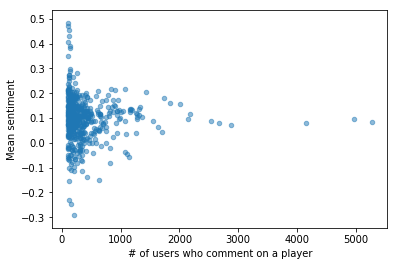

In [94]:
player_sentiment_df.query('user_count> 100').plot('user_count', 'compound_mean_mean', kind='scatter', alpha = 0.5)
#plt.plot([100, 100], [-0.1, 0.3])
plt.xlabel('# of users who comment on a player')
plt.ylabel('Mean sentiment')

#### Most commented players

In [95]:
player_sentiment_df.sort_values('user_count', ascending=False).head()

,fuzzy_name,year,compound_mean_mean,compound_mean_std,user_count
8215,tom brady,2017,0.085859,0.382076,5273
8214,tom brady,2016,0.095046,0.381020,4965
8213,tom brady,2015,0.079699,0.382783,4152
6770,peyton manning,2015,0.070516,0.391246,2884
63,aaron rodgers,2016,0.078407,0.396450,2674


#### Players with lowest sentiment

In [96]:
player_sentiment_df.query('user_count > 100').sort_values('compound_mean_mean').head()

,fuzzy_name,year,compound_mean_mean,compound_mean_std,user_count
3391,gregg williams,2017,-0.292426,0.401353,212
6095,michael bennett,2017,-0.246168,0.432726,166
3390,gregg williams,2016,-0.229989,0.425208,131
2157,danny trevathan,2017,-0.152300,0.452943,121
8634,vontaze burfict,2015,-0.148928,0.418612,627


#### Players with highest sentiment

In [97]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_mean').tail(5)

,fuzzy_name,year,compound_mean_mean,compound_mean_std,user_count
7006,reggie corner,2016,0.212758,0.432695,898
3559,j.j. watt,2016,0.215113,0.359252,1068
3560,j.j. watt,2017,0.217987,0.365602,840
2324,david johnson,2016,0.240712,0.417744,228
7567,sean mcvay,2017,0.280502,0.392170,267


In [98]:
# temporary until I re-run sentiment scoring
player_sentiment_df = player_sentiment_df.query('fuzzy_name != "devonta freeman"')

#### Players with highest std of sentiment

In [99]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_std').tail(5).iloc[::-1]

,fuzzy_name,year,compound_mean_mean,compound_mean_std,user_count
6980,ray lewis,2015,-0.066220,0.508156,230
3665,jake locker,2017,-0.022028,0.495409,823
3651,jake butt,2016,-0.072136,0.485159,350
3664,jake locker,2016,-0.013472,0.480238,663
5133,kevin boss,2017,0.016014,0.472658,406


#### Join player sentiment to performance and demographics
Include only players with at least 100 comments to avoid fitting noise

In [101]:
join_df = (player_sentiment_df.query('user_count >= 10')
                         .merge(covariates_df, left_on = ['fuzzy_name', 'year'],
                                                right_on = ['Player', 'year'])
                        )

### Explore demographics relationship with sentiment

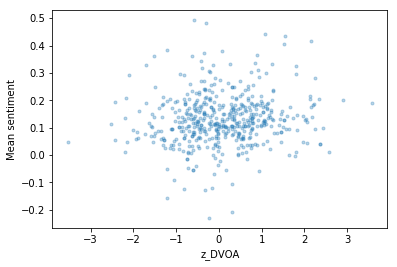

In [102]:
plt.plot(join_df['z_DVOA'].values, join_df['compound_mean_mean'].values, '.',alpha= 0.3);
plt.xlabel('z_DVOA')
plt.ylabel('Mean sentiment');

In [103]:
join_df.groupby('race').mean()

,year,compound_mean_mean,compound_mean_std,user_count,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,level_1,start_year,end_year,height,weight,salary,standard_salary,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
race,,,,,,,,,,,,,,,,,,,,,,,
B,2015.991304,0.138103,0.420482,119.026087,107.918841,0.680870,6.046377,0.016535,-0.010581,0.139980,4.118841,2011.892754,2017.707246,72.704348,214.817391,4.367726e+06,14.769618,7.971014,4.767395e+06,69.475942,15.362609,0.332255,4.098551
L,2016.000000,0.097475,0.418116,168.000000,6.000000,-11.700000,1.000000,-0.813640,-0.770682,-1.253929,5.000000,2010.000000,2016.000000,72.000000,204.000000,4.400000e+06,15.297115,11.000000,2.003144e+07,58.700000,17.100000,0.618300,6.000000
M,2017.000000,-0.003271,0.454762,19.000000,85.000000,35.000000,5.000000,0.691648,1.789748,0.734209,3.000000,2014.000000,2018.000000,75.000000,235.000000,2.746000e+06,14.825656,13.000000,6.047721e+06,67.500000,20.900000,0.669100,3.000000
S,2016.000000,0.118817,0.443402,438.200000,239.400000,4.460000,13.600000,0.019236,0.213133,-0.017613,2.600000,2013.200000,2017.400000,75.600000,216.400000,4.114634e+06,14.968948,7.600000,2.198398e+06,78.420000,11.760000,0.224721,2.800000
W,2015.985816,0.113456,0.420415,522.602837,300.468085,5.300709,13.354610,0.305794,0.275113,0.191021,6.156028,2009.815603,2017.595745,75.631206,230.319149,8.103426e+06,15.357898,8.546099,5.131045e+06,69.880142,15.158865,0.362582,6.170213


#### Age / experience

Text(0,0.5,'Mean sentiment')

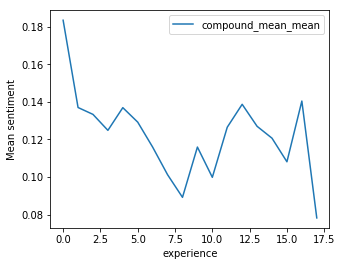

In [104]:
fig, ax1 = plt.subplots(1,1, figsize = [5, 4], sharey=True)
join_df.groupby('experience').mean().reset_index().plot('experience', 'compound_mean_mean', ax = ax1);
ax1.set_ylabel('Mean sentiment')

#### Height

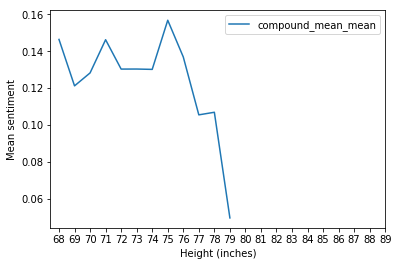

In [105]:
join_df.groupby('height').mean().reset_index().plot('height', 'compound_mean_mean');
plt.xticks(range(68,90,1) );
plt.xlabel('Height (inches)')
plt.ylabel('Mean sentiment');

### Team and position

In [106]:
join_df.groupby('position').mean().reset_index()

,position,year,compound_mean_mean,compound_mean_std,user_count,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,level_1,start_year,end_year,height,weight,salary,standard_salary,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
0,qb,2015.989691,0.108519,0.419051,781.577320,437.443299,0.663918,21.154639,0.030433,0.039127,0.062883,6.237113,2009.762887,2017.731959,75.371134,224.278351,1.096479e+07,15.732799,7.783505,5.130134e+06,69.684536,14.979381,0.344178,6.226804
1,rb,2016.049505,0.128405,0.425990,93.534653,64.900990,-0.710891,5.623762,-0.021310,-0.044858,0.096522,3.742574,2012.376238,2017.752475,71.267327,221.504950,3.069257e+06,14.468909,8.069307,4.891116e+06,69.332673,15.905941,0.355807,3.673267
2,te,2016.024390,0.137677,0.422843,108.134146,66.219512,6.189024,4.317073,0.359958,0.290994,0.373829,5.390244,2010.658537,2017.536585,76.646341,254.182927,3.921181e+06,14.809068,8.378049,4.140173e+06,69.681707,16.134146,0.329809,5.365854
3,wr,2015.953052,0.138716,0.418256,107.990610,124.267606,2.477934,5.018779,0.086758,0.066193,0.132005,4.154930,2011.765258,2017.652582,72.666667,202.525822,4.560712e+06,14.849206,8.262911,5.043098e+06,69.787324,14.797183,0.337075,4.187793


#### Create modeling dataframe

In [107]:
join_df['youth'] = (join_df['experience'].mean() - join_df['experience']).clip(0)
join_df['oldness'] = (join_df['experience'] - join_df['experience'].mean()).clip(0)
join_df['rookie'] = join_df['experience'] <=4

In [108]:
join_df['white_black_diff'] = join_df['metro_percent_white'] - join_df['metro_percent_black']
join_df['height_dummies'] = pd.cut(join_df['height'], [0, 72, 100], labels = ['short', 'tall'])
join_df['standard_salary'] = join_df['standard_salary'].fillna(join_df['standard_salary'].mean())

In [109]:
join_df.to_csv('modeling_data/nfl_model_data.tsv', sep='\t', index=False)

In [110]:
fit_df = join_df.copy().query('user_count > 20').replace({'L':'B', 'S':'B', 'M':'B'})

## Regression models

### Salary
#### Exploration

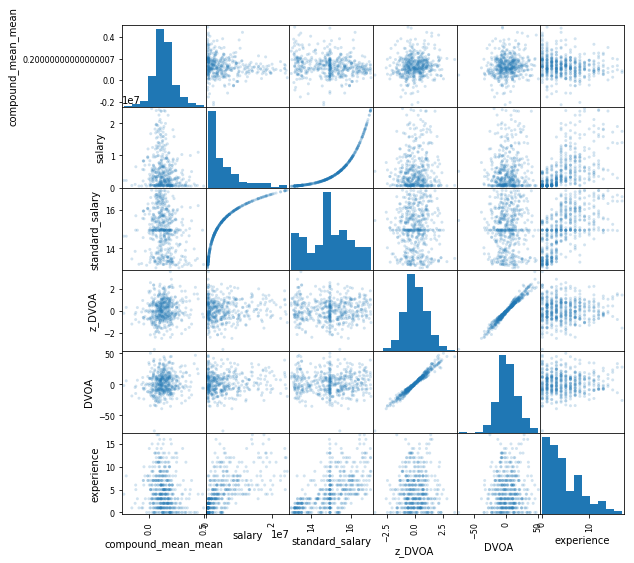

In [112]:
from pandas.plotting import scatter_matrix
scatter_matrix(join_df[['compound_mean_mean', 'salary', 'standard_salary', 'z_DVOA', 'DVOA', 'experience']], alpha=0.2, figsize=(9, 9));

In [113]:
join_df.groupby('position').mean()[['salary', 'standard_salary']]

,salary,standard_salary
position,,
qb,1.096479e+07,15.634494
rb,3.069257e+06,14.524662
te,3.921181e+06,14.834258
wr,4.560712e+06,14.857141


#### Regression

In [114]:
salary_model = smf.wls( formula = 'standard_salary ~ rookie + position + z_DVOA',
                data = fit_df,
               weights = 1,
#                missing='raise'   
               ).fit()

In [115]:
salary_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        standard_salary   R-squared:                       0.405
Model:                            WLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     53.55
Date:                Mon, 05 Nov 2018   Prob (F-statistic):           2.37e-42
Time:                        23:17:50   Log-Likelihood:                -490.20
No. Observations:                 400   AIC:                             992.4
Df Residuals:                     394   BIC:                             1016.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         16.1734      0.093    174.053      0.000      15.991      16.356
rookie[T.True]    -1.1619      0.084    -13.824      0.000      -1.327      -0.997
position[T.rb]    -0.8625      0.125     -6.890      0.000      -1.109      -0.616
position[T.te]    -0.6678      0.143     -4.669      0.000      -0.949      -0.387
position[T.wr]    -0.5945      0.106     -5.596      0.000      -0.803      -0.386
z_DVOA             0.0016      0.042      0.037      0.971      -0.082       0.085
==============================================================================
Omnibus:                        9.910   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                5.956
Skew:                          -0.116   Prob(JB):                       0.0509
Kurtosis:                       2.449   Cond. No.                         5.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Calculate residual salary

In [116]:
fit_df['pred_std_salary'] = salary_model.predict(fit_df)
fit_df['std_salary_resid'] = fit_df['pred_std_salary']- fit_df['standard_salary']
fit_df.sort_values('std_salary_resid').head(5)[['Player', 'year', 'standard_salary', 'pred_std_salary']]

,Player,year,standard_salary,pred_std_salary
119,deandre hopkins,2017,16.705882,14.418289
272,julio jones,2015,16.333207,14.417688
17,alshon jeffery,2016,16.228199,14.417547
275,julius thomas,2015,16.147654,14.342404
292,kirk cousins,2016,16.808890,15.013089


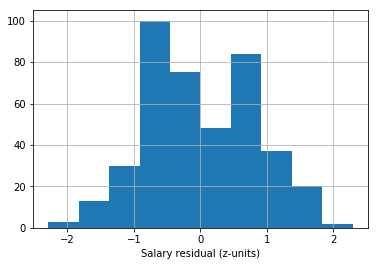

In [146]:
fit_df['std_salary_resid'].hist();
plt.xlabel('Salary residual (z-units)');

### Sentiment regression model

In [117]:

simple_model = smf.wls( formula = 'compound_mean_mean ~ youth + oldness + z_DVOA + height_dummies + position + standard_salary + std_salary_resid'\
                       ' + Wins + white_black_diff * C(race) + clinton_vote_lead',
                data = fit_df,
               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [118]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.094
Model:                            WLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     2.858
Date:                Mon, 05 Nov 2018   Prob (F-statistic):           0.000412
Time:                        23:18:01   Log-Likelihood:                 506.68
No. Observations:                 400   AIC:                            -983.4
Df Residuals:                     385   BIC:                            -923.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.1330      0.174      0.765      0.445      -0.209       0.475
height_dummies[T.tall]            0.0097      0.009      1.131      0.259      -0.007       0.027
position[T.rb]                    0.0160      0.015      1.043      0.297      -0.014       0.046
position[T.te]                    0.0138      0.013      1.033      0.302      -0.012       0.040
position[T.wr]                    0.0102      0.012      0.841      0.401      -0.014       0.034
C(race)[T.W]                      0.0215      0.024      0.899      0.369      -0.026       0.069
youth                             0.0035      0.004      1.001      0.317      -0.003       0.010
oldness                          -0.0004      0.001     -0.302      0.763      -0.003       0.002
z_DVOA                            0.0125      0.003      3.592      0.000       0.006       0.019
standard_salary                  -0.0026      0.011     -0.238      0.812      -0.024       0.019
std_salary_resid                  0.0044      0.010      0.420      0.675      -0.016       0.025
Wins                             -0.0012      0.001     -1.009      0.313      -0.003       0.001
white_black_diff                  0.0002      0.000      0.834      0.405      -0.000       0.001
white_black_diff:C(race)[T.W]    -0.0006      0.000     -1.460      0.145      -0.001       0.000
clinton_vote_lead                 0.0158      0.016      0.968      0.334      -0.016       0.048
==============================================================================
Omnibus:                       21.723   Durbin-Watson:                   1.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.742
Skew:                           0.194   Prob(JB):                     1.30e-12
Kurtosis:                       4.771   Cond. No.                     3.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Coaches

In [63]:
coaches_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_coach_performance.tsv', sep='\t')
coaches_race_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_coach_race.tsv', sep='\t')

In [64]:
team_win_df = coaches_df.groupby(['Tm', 'year']).sum()['W'].reset_index()
team_win_df['season_WinP'] = team_win_df['W'] / 16
team_win_df.sample(5)

,Tm,year,W,season_WinP
1362,New Orleans Saints,2010,11.0,0.6875
881,Green Bay Packers,2005,4.0,0.2500
2117,Washington Redskins,2009,4.0,0.2500
1386,New York Giants,1938,8.0,0.5000
1947,St. Louis Cardinals,1984,9.0,0.5625


In [65]:
coaches_df['prev_year'] = coaches_df['year']-1
coaches_df = coaches_df.merge(team_win_df.rename(columns = {'year': 'prev_year'}),
                              on = ['prev_year', 'Tm'], how='left', suffixes = ('', '_prev') )
coaches_df['winP_change'] = (coaches_df['season_WinP'] - coaches_df['season_WinP_prev']).fillna(0)
coaches_df['Coach'] = coaches_df['Coach'].str.lower()
coaches_race_df['Coach'] = coaches_race_df['Coach'].str.lower()

In [66]:
coaches_df.head(3)

,year,age,Tm,league,G,W,L,Tie,season_WinP,career_WinP,Coach,prev_year,W_prev,season_WinP_prev,winP_change
0,1963,33.0,Baltimore Colts,NFL,14,8.0,6.0,0.0,0.571,0.677,don shula,1962,7.0,0.4375,0.1335
1,1964,34.0,Baltimore Colts,NFL,14,12.0,2.0,0.0,0.857,0.677,don shula,1963,8.0,0.5000,0.3570
2,1965,35.0,Baltimore Colts,NFL,14,10.0,3.0,1.0,0.769,0.677,don shula,1964,12.0,0.7500,0.0190


In [67]:
coaches_covariates_df = (coaches_df.merge(coaches_race_df, on = 'Coach')
                                   .rename(columns = {'Coach':'fuzzy_name'})
                                   .merge(player_sentiment_df, on = ['fuzzy_name', 'year'], how='inner')
                                   )

### Most and least popular coaches

In [69]:
coaches_covariates_df.sort_values('compound_mean_mean',ascending=False).head(5)

,year,age,Tm,league,G,W,L,Tie,season_WinP,career_WinP,fuzzy_name,prev_year,W_prev,season_WinP_prev,winP_change,race,compound_mean_mean,compound_mean_std,user_count
86,2016,48.0,Buffalo Bills,NFL,1,0.0,1.0,0.0,0.000,0.583,anthony lynn,2015,8.0,0.5000,-0.5000,B,0.490191,0.387365,11
99,2016,42.0,Los Angeles Rams,NFL,3,0.0,3.0,0.0,0.000,0.000,john fassel,2015,NaN,NaN,0.0000,W,0.471736,0.322150,11
81,2017,31.0,Los Angeles Rams,NFL,16,11.0,5.0,0.0,0.688,0.792,sean mcvay,2016,4.0,0.2500,0.4380,W,0.280502,0.392170,267
79,2016,38.0,Miami Dolphins,NFL,16,10.0,6.0,0.0,0.625,0.500,adam gase,2015,1.0,0.0625,0.5625,W,0.266910,0.376207,187
73,2015,52.0,New York Jets,NFL,16,10.0,6.0,0.0,0.625,0.424,todd bowles,2014,4.0,0.2500,0.3750,B,0.265183,0.386048,127


In [68]:
coaches_covariates_df.sort_values('compound_mean_mean',ascending=False).tail(5)

,year,age,Tm,league,G,W,L,Tie,season_WinP,career_WinP,fuzzy_name,prev_year,W_prev,season_WinP_prev,winP_change,race,compound_mean_mean,compound_mean_std,user_count
47,2015,55.0,Indianapolis Colts,NFL,16,8.0,8.0,0.0,0.500,0.552,chuck pagano,2014,11.0,0.6875,-0.1875,W,-0.051422,0.430797,299
65,2017,50.0,Washington Redskins,NFL,16,7.0,9.0,0.0,0.438,0.472,jay gruden,2016,8.0,0.5000,-0.0620,W,-0.052387,0.494077,20
40,2016,54.0,Carolina Panthers,NFL,16,6.0,10.0,0.0,0.375,0.584,ron rivera,2015,15.0,0.9375,-0.5625,W,-0.071170,0.456273,35
26,2017,54.0,New Orleans Saints,NFL,16,11.0,5.0,0.0,0.688,0.607,sean payton,2016,7.0,0.4375,0.2505,W,-0.112689,0.445694,214
94,2017,58.0,New York Giants,NFL,4,1.0,3.0,0.0,0.250,0.212,steve spagnuolo,2016,11.0,0.6875,-0.4375,W,-0.127200,0.444799,6


### Filter to coaches with enough games and comments and explore data

In [70]:
coaches_fit_df = coaches_covariates_df.query('G >= 10 and user_count > 10')

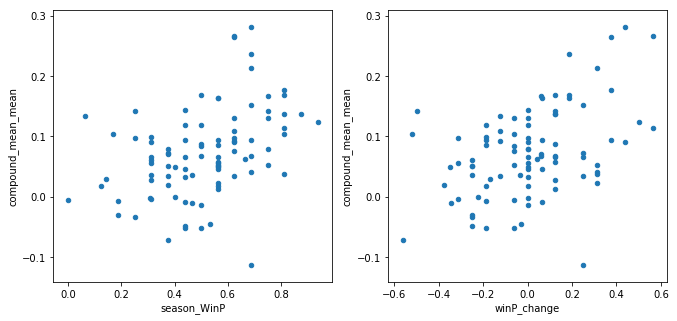

In [71]:
fig, axes = plt.subplots(1,2, figsize = [11, 5])
coaches_fit_df.plot.scatter('season_WinP', 'compound_mean_mean', ax = axes[0]);
coaches_fit_df.plot.scatter('winP_change', 'compound_mean_mean', ax = axes[1]);

In [78]:
coaches_fit_df.groupby('race').agg(['mean', 'count'])['compound_mean_mean']

,mean,count
race,,
B,0.069253,17
W,0.073728,75


#### Regression model

In [79]:
'''model = sm.WLS( fit_df['compound_mean_mean'].values,
               fit_df[['youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall',
                       'PS/G', '3P%' , 'TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS']],
               fit_df['user_count']).fit()'''
coach_model = smf.wls( formula = 'compound_mean_mean ~ season_WinP + career_WinP + winP_change + C(race)',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [80]:
coach_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.292
Model:                            WLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     8.962
Date:                Wed, 07 Nov 2018   Prob (F-statistic):           4.15e-06
Time:                        23:16:44   Log-Likelihood:                 115.75
No. Observations:                  92   AIC:                            -221.5
Df Residuals:                      87   BIC:                            -208.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0073      0.036      0.205      0.838      -0.063       0.078
C(race)[T.W]    -0.0012      0.020     -0.060      0.952      -0.040       0.038
season_WinP      0.0884      0.058      1.522      0.132      -0.027       0.204
career_WinP      0.0437      0.093      0.469      0.641      -0.142       0.229
winP_change      0.1086      0.038      2.851      0.005       0.033       0.184
==============================================================================
Omnibus:                        9.197   Durbin-Watson:                   1.562
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               20.642
Skew:                          -0.124   Prob(JB):                     3.29e-05
Kurtosis:                       5.307   Cond. No.                         23.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""